In [ ]:
import sys
sys.path.append('/scratch/nf33/sc5932/hk25-AusNode-TConvZones/functions')

from SC_function import get_nn_lon_lat_index

import xarray as xr
import healpy as hp
import easygems.healpix as egh
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from dask.diagnostics import ProgressBar


## read model data

In [63]:
zoom = '7'
file_uk = '/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z' + zoom + '.zarr'
file_germany = "/g/data/qx55/germany_node/d3hp003.zarr/P1D_point_z" + zoom + "_atm.zarr"

time_start = "2020-02-01"
time_end = "2021-02-28"

# Uk node
ds_uk_1h_z5 = xr.open_zarr(file_uk).pr*3600
ds_uk_daily = ds_uk_1h_z5.resample(time="1D").sum()
mean_uk = ds_uk_daily.sel(time=slice(time_start, time_end)).mean(dim="time")

# Germany node
ds_germany_1d_z5 = xr.open_zarr(file_germany).pr*86400
mean_germany = ds_germany_1d_z5.sel(time=slice(time_start, time_end)).mean(dim="time")

# plot by healpix
# egh.healpix_show(mean_germany, cmap="Blues", dpi=72,vmin=0,vmax=10)


## ERA5

In [ ]:
files = [
    '/g/data/rt52/era5/single-levels/reanalysis/tp/2020/*.nc',
    '/g/data/rt52/era5/single-levels/reanalysis/tp/2021/*.nc'
]
ds_era5 = xr.concat([xr.open_mfdataset(f, combine='nested', concat_dim='time') for f in files], dim='time')

ds_era5_daily = ds_era5.tp.resample(time="1D").sum()
mean_era5 = ds_era5_daily.sel(time=slice(time_start,time_end)).mean(dim="time") * 1000  #original unit is meter

In [ ]:
with ProgressBar():
    mean_era5_loaded = mean_era5.load()

[########################################] | 100% Completed | 200.77 s


## plot

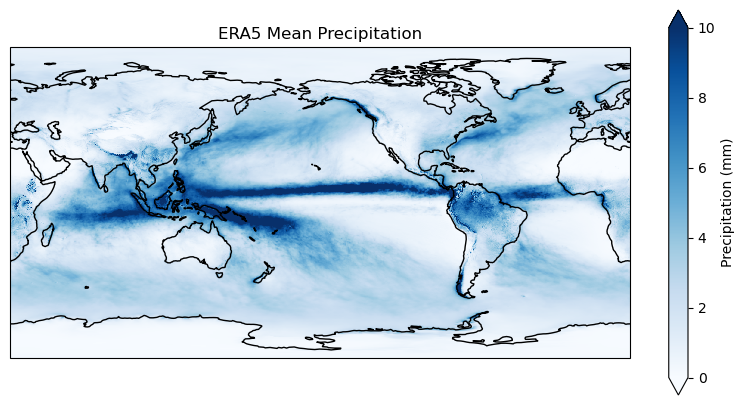

In [32]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

projection = ccrs.PlateCarree(central_longitude=205)

# Create figure and axes with projection
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": projection})

# Plot with vmin and vmax set
mean_era5_loaded.plot(
    ax=ax,
    cmap='Blues',
    vmin=0,         # Set your desired minimum color value
    vmax=10,        # Set your desired maximum color value
    transform=ccrs.PlateCarree(),  
    cbar_kwargs={"label": "Precipitation (mm)"}
)

# Add coastlines and title
ax.coastlines()
ax.set_title('ERA5 Mean Precipitation')

plt.show()


## regrid the model to era5

In [58]:
# longitudes and latitudes for the ERA5 grid
lon = mean_era5['longitude'].values
lat = mean_era5['latitude'].values

# nside for um simulation, it should be equal to 2**zoom
this_nside = hp.get_nside(mean_uk)

cells = get_nn_lon_lat_index(this_nside, lon, lat) 

mean_uk_regrid = mean_uk.isel(cell = cells)

Text(0.5, 1.0, 'UM Daily Mean Precipitation from Feb 2020 to March 2021')

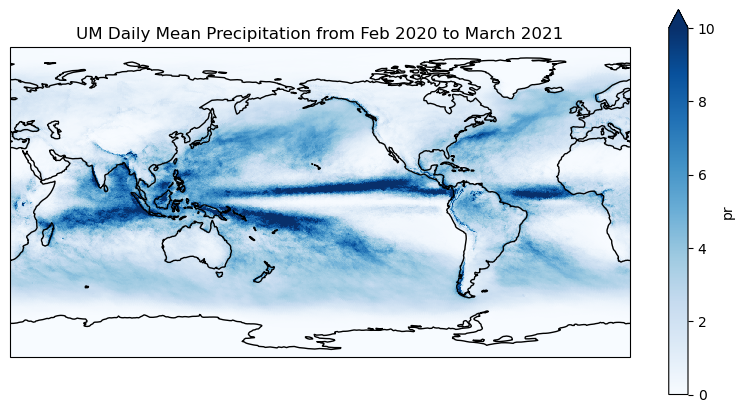

In [59]:

projection = ccrs.PlateCarree(central_longitude=205)

fig, ax = plt.subplots(figsize=(10, 5),subplot_kw = {"projection": projection})
mean_uk_regrid.plot(cmap = 'Blues', vmin = 0, vmax = 10,transform = ccrs.PlateCarree())
ax.coastlines()
ax.set_title('UM Daily Mean Precipitation from Feb 2020 to March 2021')

In [66]:
lon = mean_era5['longitude'].values
lat = mean_era5['latitude'].values
this_nside = hp.get_nside(mean_germany)

cells = get_nn_lon_lat_index(this_nside, lon, lat) 

mean_germany_regrid = mean_germany.isel(cell = cells)

Text(0.5, 1.0, ' ICON Daily Mean Precipitation from Feb 2020 to March 2021')

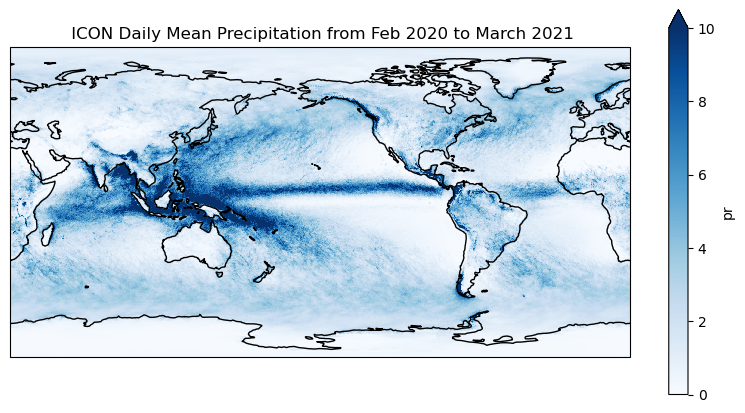

In [68]:

projection = ccrs.PlateCarree(central_longitude=205)

fig, ax = plt.subplots(figsize=(10, 5),subplot_kw = {"projection": projection})
mean_germany_regrid.plot(cmap = 'Blues', vmin = 0, vmax = 10,transform = ccrs.PlateCarree())
ax.coastlines()
ax.set_title(' ICON Daily Mean Precipitation from Feb 2020 to March 2021')